In [10]:
# Standard Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

In [11]:
# Load data
df = pd.read_csv("../data/togo-dapaong_qc.csv")
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

In [12]:
# Summary
df.describe()

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
count,525600,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,0.0
mean,2022-04-25 12:00:30.000000768,230.555040,151.258469,116.444352,226.144375,219.568588,27.751788,55.013160,2.368093,3.229490,0.557740,161.741845,10.559568,975.915242,0.000535,0.001382,32.444403,33.543330,NaN
min,2021-10-25 00:01:00,-12.700000,0.000000,0.000000,0.000000,0.000000,14.900000,3.300000,0.000000,0.000000,0.000000,0.000000,0.000000,968.000000,0.000000,0.000000,13.100000,13.100000,NaN
25%,2022-01-24 06:00:45,-2.200000,0.000000,0.000000,0.000000,0.000000,24.200000,26.500000,1.400000,1.900000,0.400000,74.800000,6.900000,975.000000,0.000000,0.000000,23.900000,23.600000,NaN
50%,2022-04-25 12:00:30,2.100000,0.000000,2.500000,4.400000,4.300000,27.200000,59.300000,2.200000,2.900000,0.500000,199.100000,10.800000,976.000000,0.000000,0.000000,28.400000,28.400000,NaN
75%,2022-07-25 18:00:15,442.400000,246.400000,215.700000,422.525000,411.000000,31.100000,80.800000,3.200000,4.400000,0.700000,233.500000,14.100000,977.000000,0.000000,0.000000,40.600000,43.000000,NaN
max,2022-10-25 00:00:00,1424.000000,1004.500000,805.700000,1380.000000,1367.000000,41.400000,99.800000,16.100000,23.100000,4.700000,360.000000,86.900000,983.000000,1.000000,2.300000,70.400000,94.600000,NaN
std,NaN,322.532347,250.956962,156.520714,317.346938,307.932510,4.758023,28.778732,1.462668,1.882565,0.268923,91.877217,5.915490,2.153977,0.023116,0.026350,10.998334,12.769277,NaN


In [13]:
# Missing values
missing = df.isna().sum()
missing_percent = (missing / len(df)) * 100
missing_report = pd.DataFrame({'Missing': missing, 'Percent': missing_percent})
missing_report[missing_report['Percent'] > 5]

,Missing,Percent
Comments,525600,100.0


In [14]:
# Z-score outlier filtering
z_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
z_scores = df[z_cols].apply(zscore)
outlier_mask = (np.abs(z_scores) > 3)

In [15]:
# Drop rows with extreme values
df_clean = df[(~outlier_mask).all(axis=1)].copy()

In [16]:
df_clean.fillna(df_clean.median(numeric_only=True), inplace=True)

In [17]:
# Save cleaned version
import os
os.makedirs("../data", exist_ok=True)
df_clean.to_csv("../data/togo_clean.csv", index=False)

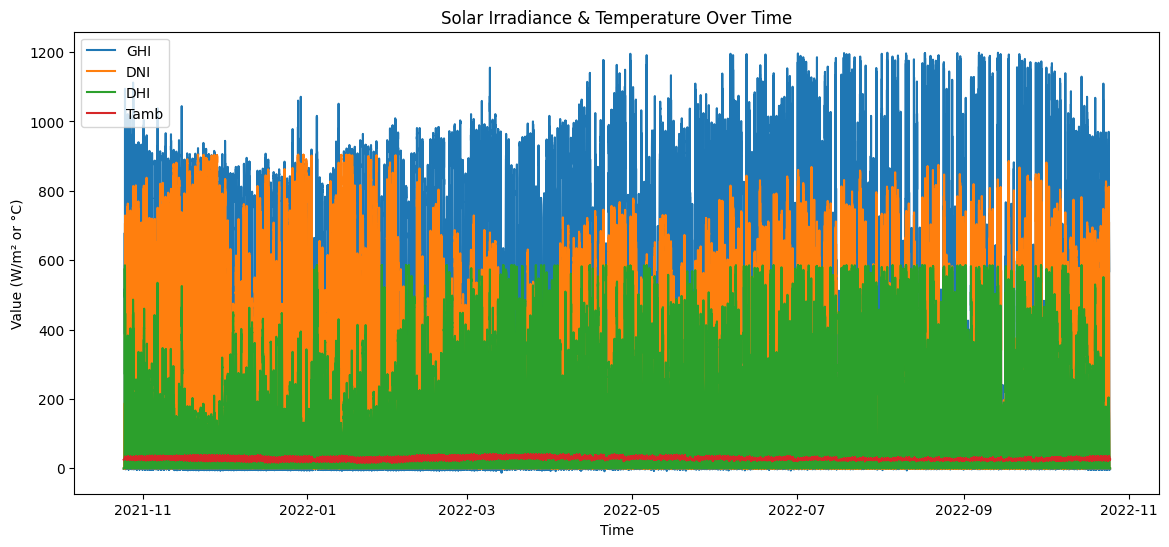

In [18]:
plt.figure(figsize=(14, 6))
for col in ['GHI', 'DNI', 'DHI', 'Tamb']:
    plt.plot(df_clean['Timestamp'], df_clean[col], label=col)
plt.legend()
plt.title("Solar Irradiance & Temperature Over Time")
plt.xlabel("Time")
plt.ylabel("Value (W/m² or °C)")
plt.show()

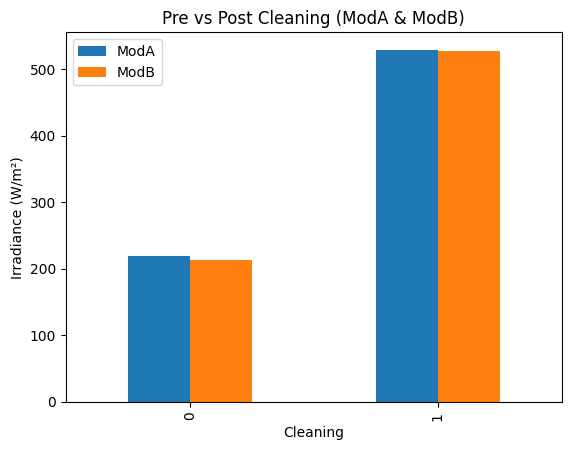

In [19]:
df_clean.groupby('Cleaning')[['ModA', 'ModB']].mean().plot(kind='bar')
plt.title("Pre vs Post Cleaning (ModA & ModB)")
plt.ylabel("Irradiance (W/m²)")
plt.show()

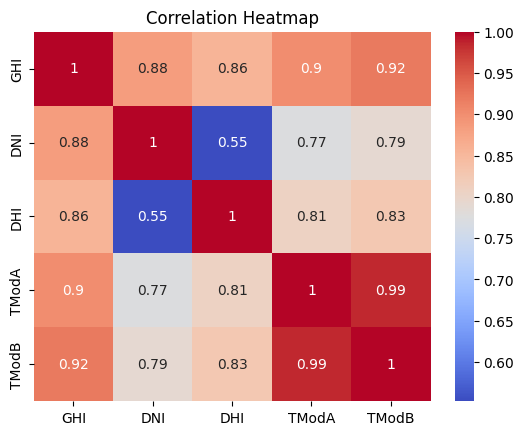

In [20]:
corr = df_clean[['GHI', 'DNI', 'DHI', 'TModA', 'TModB']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

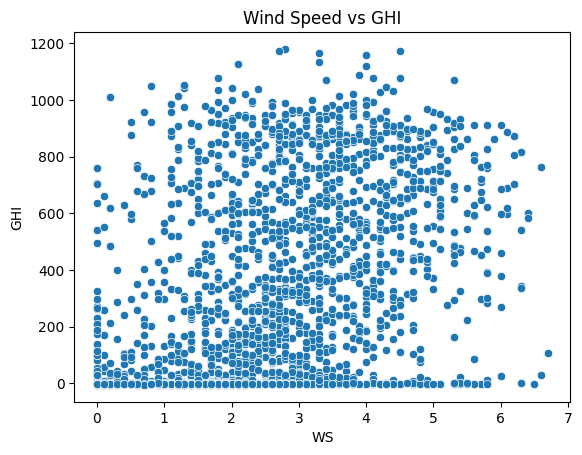

In [21]:
# Relationship: WS vs GHI
sns.scatterplot(data=df_clean.sample(3000), x='WS', y='GHI')
plt.title("Wind Speed vs GHI")
plt.show()

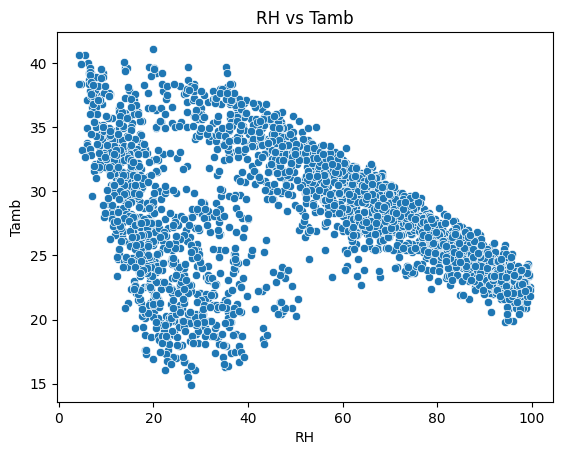

In [22]:
# Relationship: RH vs Tamb
sns.scatterplot(data=df_clean.sample(3000), x='RH', y='Tamb')
plt.title("RH vs Tamb")
plt.show()

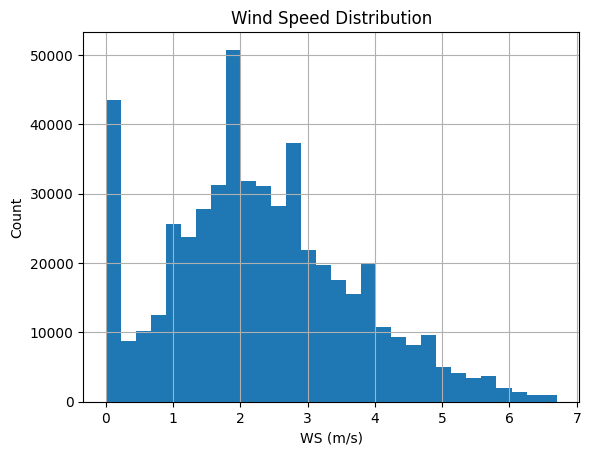

In [23]:
# Histogram of WS
df_clean['WS'].hist(bins=30)
plt.title("Wind Speed Distribution")
plt.xlabel("WS (m/s)")
plt.ylabel("Count")
plt.show()

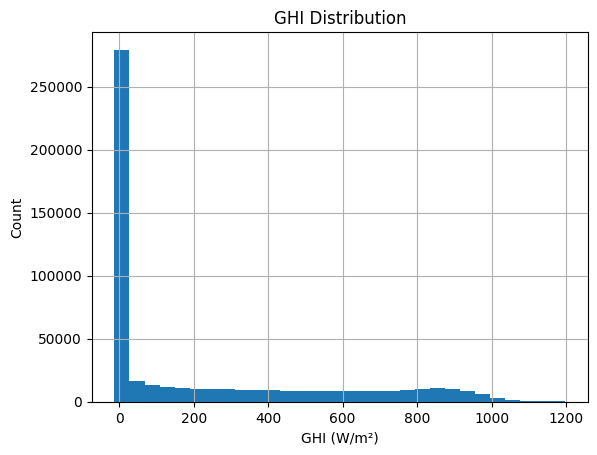

In [24]:
# Histogram of GHI
df_clean['GHI'].hist(bins=30)
plt.title("GHI Distribution")
plt.xlabel("GHI (W/m²)")
plt.ylabel("Count")
plt.show()

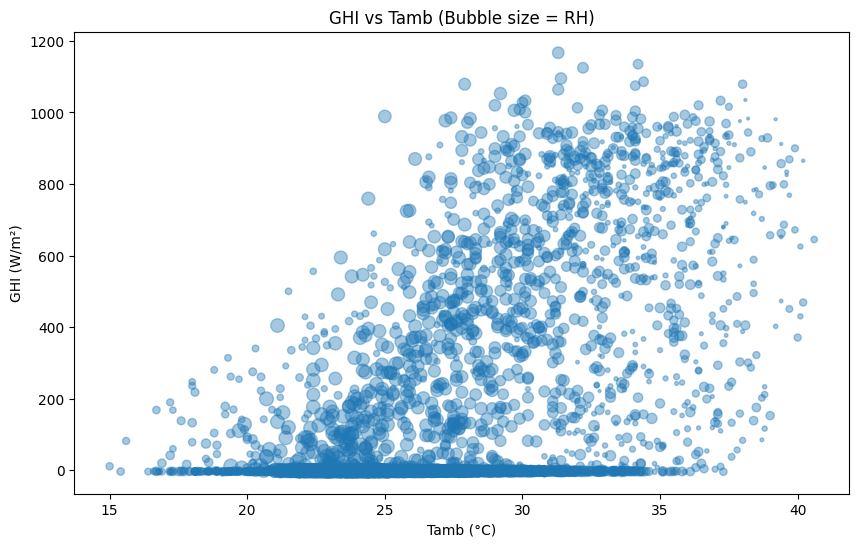

In [25]:
# GHI vs Tamb, Bubble Size = RH
sample = df_clean.sample(3000)
plt.figure(figsize=(10, 6))
plt.scatter(sample['Tamb'], sample['GHI'], s=sample['RH'], alpha=0.4)
plt.title("GHI vs Tamb (Bubble size = RH)")
plt.xlabel("Tamb (°C)")
plt.ylabel("GHI (W/m²)")
plt.show()